In [ ]:
import pandas as pd
import io
from google.colab import files
uploaded = files.upload()
housing=pd.read_csv(io.BytesIO(uploaded['Housing_dataset.csv']))
housing.head()

Saving Housing_dataset.csv to Housing_dataset (2).csv


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,facilities
0,79.56,8.04,16,18,6.0,3,4,39.664,14000000,near by bus stand
1,83.38,7.62,26,18,3.0,5,3,39.664,11000000,near hospital
2,80.21,9.21,4,2,2.0,6,2,175.750,5500000,near hospital
3,80.24,9.22,4,18,3.0,8,6,120.250,11000000,near hospital
4,81.05,7.86,1,6,2.0,8,2,120.250,2200000,near hospital


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           2000 non-null   float64
 1   latitude            2000 non-null   float64
 2   housing_median_age  2000 non-null   int64  
 3   total_rooms         2000 non-null   int64  
 4   total_bedrooms      1984 non-null   float64
 5   population          2000 non-null   int64  
 6   households          2000 non-null   int64  
 7   median_income       2000 non-null   float64
 8   median_house_value  2000 non-null   int64  
 9   facilities          2000 non-null   object 
dtypes: float64(4), int64(5), object(1)
memory usage: 156.4+ KB


In [ ]:
housing.facilities.value_counts()


near by bus stand               823
near hospital                   682
Near school and hospital        255
near school                     235
far from school and hospital      5
Name: facilities, dtype: int64

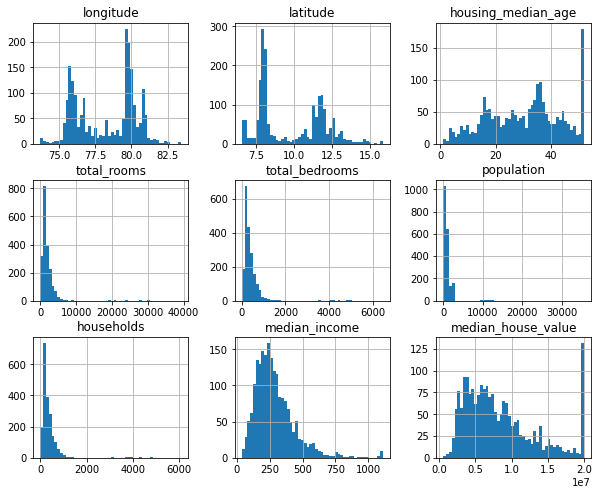

In [ ]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(10, 8))
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

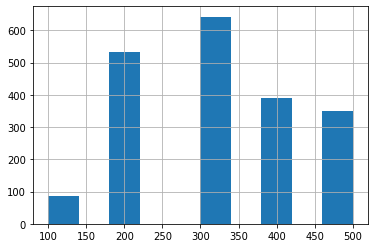

In [ ]:
import numpy as np
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 100, 200, 300, 400., np.inf], labels=[100, 200, 300, 400, 500])
housing['income_cat'].hist()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print(strat_test_set['income_cat'].value_counts() / len(strat_test_set))

300    0.3200
200    0.2675
400    0.1950
500    0.1750
100    0.0425
Name: income_cat, dtype: float64


In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
housing = strat_train_set.copy()

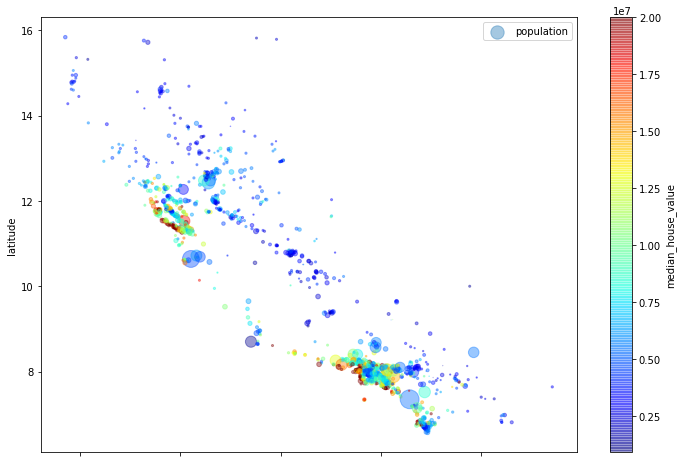

In [ ]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population',
figsize=(12, 8), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

In [ ]:
corr_matrix = housing.corr()
print(corr_matrix.median_house_value.sort_values(ascending=False))

median_house_value    1.000000
median_income         0.702582
housing_median_age    0.101431
total_rooms           0.078354
households            0.033389
total_bedrooms        0.021093
longitude            -0.008021
population           -0.013034
latitude             -0.189642
Name: median_house_value, dtype: float64


In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.702582
rooms_per_household         0.155716
housing_median_age          0.101431
total_rooms                 0.078354
households                  0.033389
total_bedrooms              0.021093
longitude                  -0.008021
population                 -0.013034
population_per_household   -0.165108
latitude                   -0.189642
bedrooms_per_room          -0.257624
Name: median_house_value, dtype: float64


In [ ]:
# Data Preparation
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

housing_num = housing.drop("facilities", axis=1)

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [ ]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["facilities"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

data = housing.iloc[:8]
labels = housing_labels.iloc[:8]
data_preparation = full_pipeline.transform(data)
print("Predictions: ", lin_reg.predict(data_preparation))

Predictions:  [ 9485848.55287759 11573084.65565862  8572826.10004388  5849282.91450822
  9807846.00996109 13870828.22051552  3154251.83715113 13227466.25395313]
